# (25) corrupt analysis

**Motivation**: host = ```mach```, device = ```cuda:0``` <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
# sys.path.insert(0, os.path.join(git_dir, '_PoissonVAE'))
sys.path.insert(0, os.path.join(git_dir, '_IterativeVAE'))
from figures.fighelper import *
from vae.train_vae import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
from base.utils_model import load_quick
from figures.analysis import plot_convergence
from figures.imgs import plot_weights

device_idx = 0
device = f'cuda:{device_idx}'

print(f"device: {device}  ———  host: {os.uname().nodename}")

device: cuda:0  ———  host: mach

In [3]:
from analysis.corrupt import perform_corruption_analysis

load_dir = pjoin(tmp_dir, 'corrupted_data')
files = sorted(os.listdir(load_dir), key=alphanum_sort_key)

## 0 - Load trainers

In [4]:
models2load = {
    'poisson_MNIST_(64,24.0)_<jacob|mlp>': dict(
        model_name='poisson_MNIST_t-64_z-[128]_<jacob|mlp>',
        fit_name='b200-ep400-lr(0.002)_beta(24:0x0.1)_temp(0.05:lin-0.5)_gr(50)_(2024_09_24,13:41)',
    ),
}
kws = dict(
    device=device,
    shuffle=False,
    strict=True,
)
models2load = {
    k: {**d, **kws} for
    k, d in models2load.items()
}

In [5]:
trainers = {
    name: load_model(**kwargs)[0] for
    name, kwargs in models2load.items()
}
tr = trainers['poisson_MNIST_(64,24.0)_<jacob|mlp>']

In [6]:
tr.model.cfg.clamp_u, tr.model.cfg.clamp_du

(8.0, 7.0)

### sanity check

plot: ftrs, convergence

poisson_MNIST_(64,24.0)_<jacob|mlp>

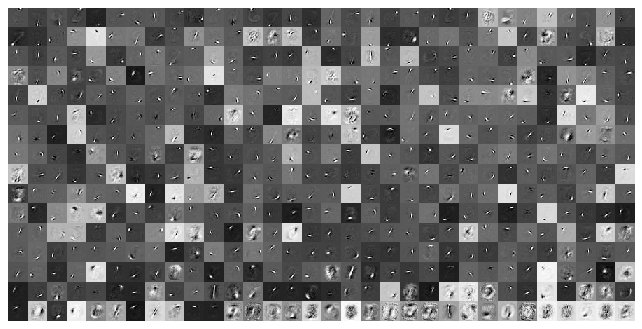

In [7]:
for name, _tr in trainers.items():
    print(name)

    w = _tr.model.layer.get_weight()
    norms = tonp(torch.linalg.vector_norm(w, dim=1))
    _tr.model.show(order=np.argsort(norms), dpi=80, pad=0)

100%|█████████████████████████████████| 50/50 [39:47<00:00, 47.75s/it]


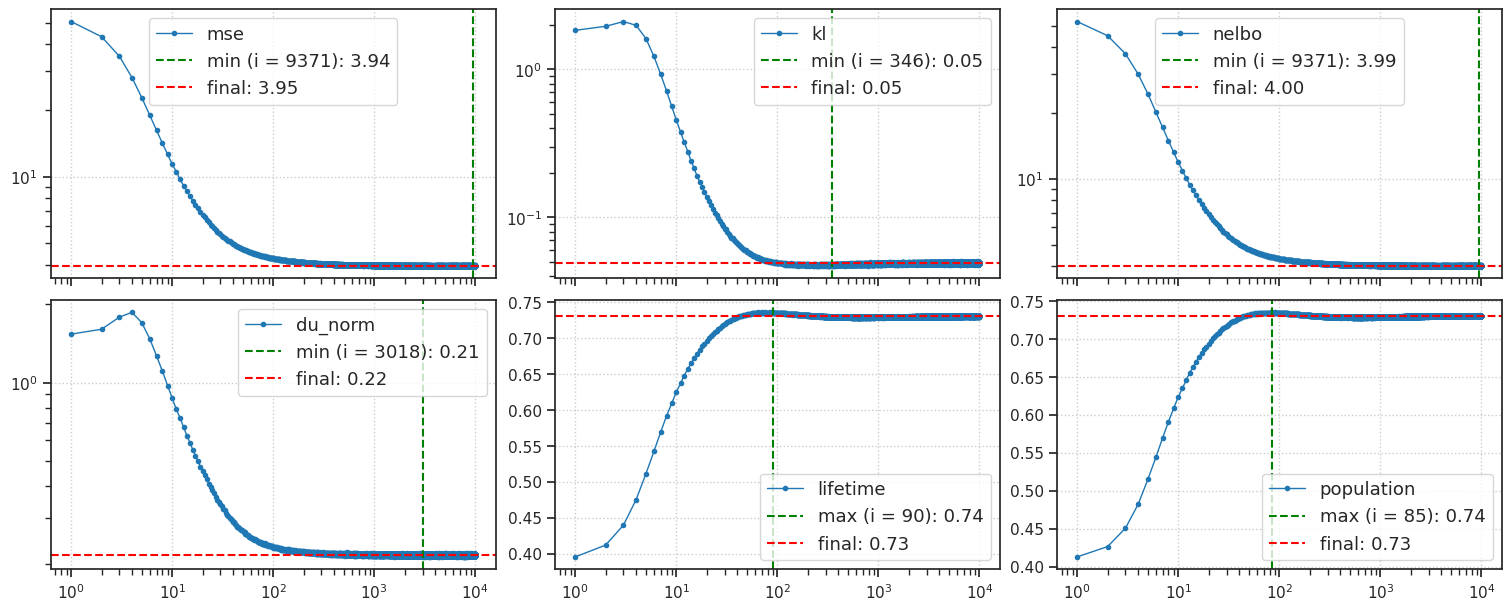

In [8]:
results = tr.analysis('vld', seq_total=10000)
_ = plot_convergence(results, color='C0')

## 1- Noise

In [9]:
tgt_ds = 'MNIST'
pat = 'noise-sigma'
val = 0.6

f = next(
    f for f in files if (
        f.startswith(tgt_ds) and
        f"{pat}-{val}" in f
    )
)
print(f)

MNIST_noise-sigma-0.6.npy

In [10]:
corrupted_data = np.load(pjoin(load_dir, f), allow_pickle=True).item()
print({k: v for k, v in corrupted_data.items() if not k.startswith('x_')})

{'corruption_type': 'noise', 'corruption_kws': {'sigma': 0.6, 'mean': 0, 'clip': False}}

In [11]:
kws = dict(
    tr=trainers['poisson_MNIST_(64,24.0)_<jacob|mlp>'],
    corrupted_data=corrupted_data,
    t_recon=-1,
    verbose=True,
)
results, accuracy = perform_corruption_analysis(**kws)

100%|█████████████████████████████████████████| 300/300 [01:21<00:00,  3.70it/s]


In [12]:
accuracy, results['mse'].mean()

(0.8888, 10.347059)

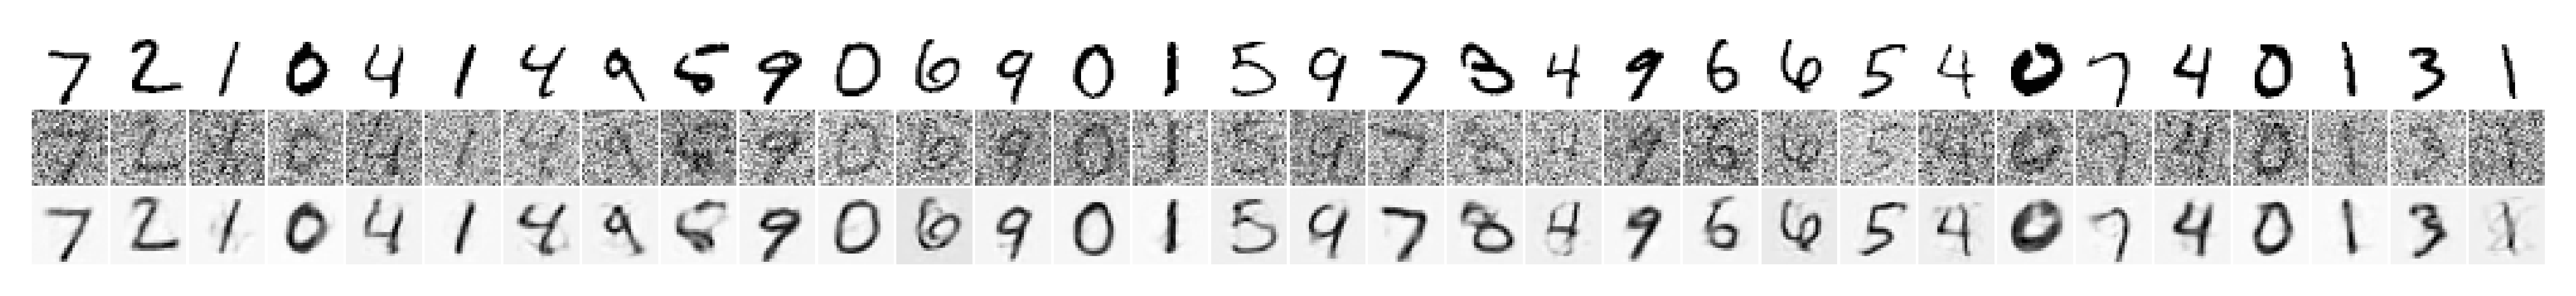

In [13]:
num = 32

x2p = np.concatenate([
    tonp(tr.dl_vld.dataset.tensors[0][:num]),
    corrupted_data['x_corrupted_vld'][:num],
    results['recon'][:num].reshape(tr.model.cfg.shape),
])
_ = plot_weights(x2p, nrows=3, cmap='Greys', dpi=500)

## 2 - Blur

In [14]:
tgt_ds = 'MNIST'
pat = 'blur-sigma'
val = 2.0

f = next(
    f for f in files if (
        f.startswith(tgt_ds) and
        f"{pat}-{val}" in f
    )
)
print(f)

MNIST_blur-sigma-2.0.npy

In [15]:
corrupted_data = np.load(pjoin(load_dir, f), allow_pickle=True).item()
print({k: v for k, v in corrupted_data.items() if not k.startswith('x_')})

{'corruption_type': 'blur', 'corruption_kws': {'sigma': 2.0, 'kernel_size': 13}}

In [16]:
kws = dict(
    tr=trainers['poisson_MNIST_(64,24.0)_<jacob|mlp>'],
    corrupted_data=corrupted_data,
    t_recon=-1,
    t_halluc=-1,
    hallucinate=False,
    verbose=True,
)
results, accuracy = perform_corruption_analysis(**kws)

100%|█████████████████████████████████████████| 300/300 [01:23<00:00,  3.58it/s]


In [17]:
accuracy, results['mse'].mean()

(0.9506, 24.04933)

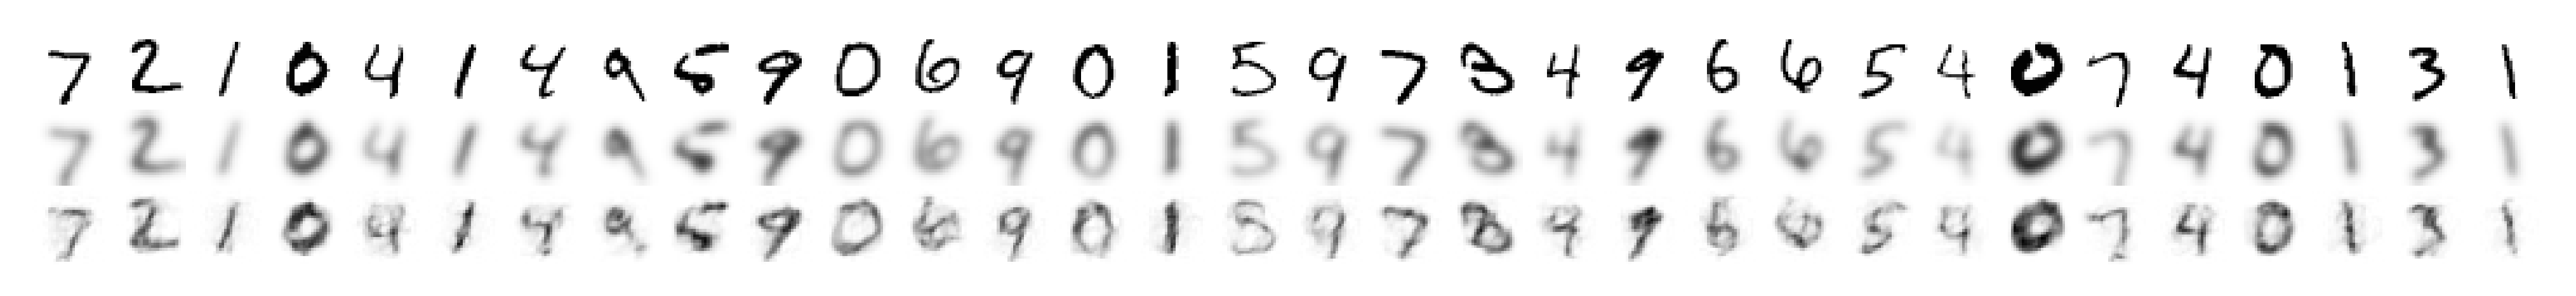

In [18]:
num = 32

x2p = np.concatenate([
    tonp(tr.dl_vld.dataset.tensors[0][:num]),
    corrupted_data['x_corrupted_vld'][:num],
    results['recon'][:num].reshape(tr.model.cfg.shape),
])
_ = plot_weights(x2p, nrows=3, cmap='Greys', method='none', vmin=1e-3, vmax=1.0, dpi=500)

## 3 - Speckle

In [19]:
tgt_ds = 'MNIST'
pat = 'speckle-std'
val = 3.0

f = next(
    f for f in files if (
        f.startswith(tgt_ds) and
        f"{pat}-{val}" in f
    )
)
print(f)

MNIST_speckle-std-3.0.npy

In [20]:
corrupted_data = np.load(pjoin(load_dir, f), allow_pickle=True).item()
print({k: v for k, v in corrupted_data.items() if not k.startswith('x_')})

{'corruption_type': 'speckle', 'corruption_kws': {'std': 3.0, 'mu': 0.0, 'clamp': False}}

In [21]:
kws = dict(
    tr=trainers['poisson_MNIST_(64,24.0)_<jacob|mlp>'],
    corrupted_data=corrupted_data,
    t_recon=-1,
    t_halluc=-1,
    hallucinate=False,
    verbose=True,
)
results, accuracy = perform_corruption_analysis(**kws)

100%|█████████████████████████████████████████| 300/300 [01:20<00:00,  3.71it/s]


In [22]:
accuracy, results['mse'].mean()

(0.7349, 28.154816)

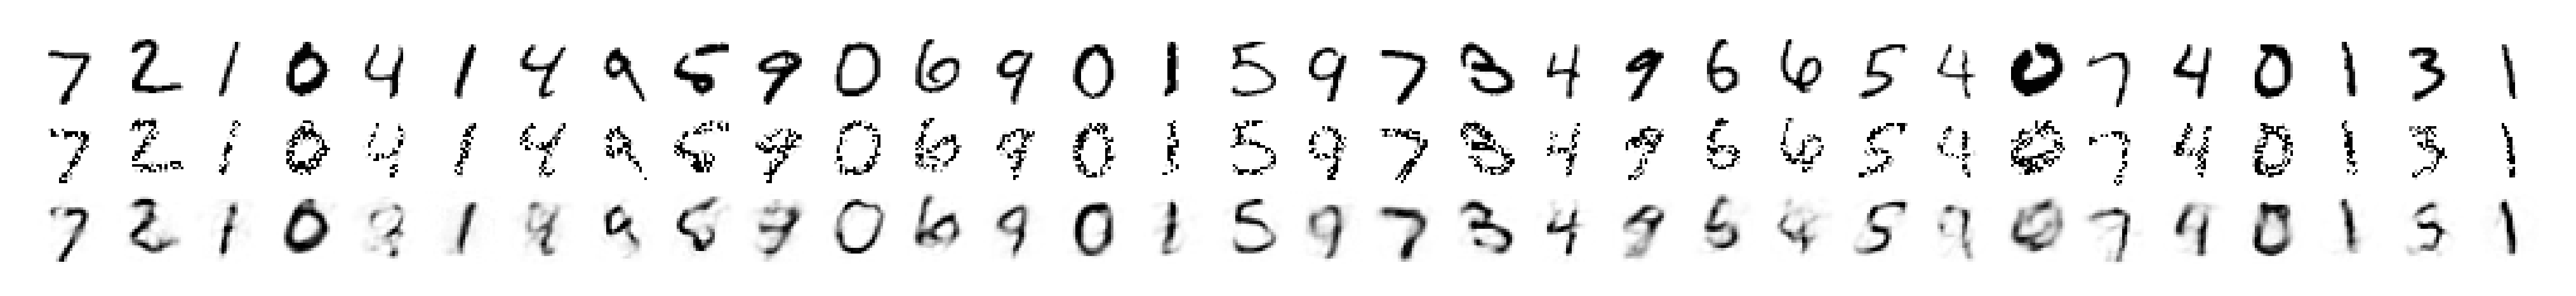

In [23]:
num = 32

x2p = np.concatenate([
    tonp(tr.dl_vld.dataset.tensors[0][:num]),
    corrupted_data['x_corrupted_vld'][:num],
    results['recon'][:num].reshape(tr.model.cfg.shape),
])
_ = plot_weights(x2p, nrows=3, cmap='Greys', method='none', vmin=1e-3, vmax=1.0, dpi=500)

## 4 - Contrast

In [24]:
tgt_ds = 'MNIST'
pat = 'contrast-contrast_factor'
val = 0.3

f = next(
    f for f in files if (
        f.startswith(tgt_ds) and
        f"{pat}-{val}" in f
    )
)
print(f)

MNIST_contrast-contrast_factor-0.3.npy

In [25]:
corrupted_data = np.load(pjoin(load_dir, f), allow_pickle=True).item()
print({k: v for k, v in corrupted_data.items() if not k.startswith('x_')})

{'corruption_type': 'contrast', 'corruption_kws': {'contrast_factor': 0.3}}

In [26]:
kws = dict(
    tr=trainers['poisson_MNIST_(64,24.0)_<jacob|mlp>'],
    corrupted_data=corrupted_data,
    t_recon=-1,
    t_halluc=-1,
    hallucinate=False,
    verbose=True,
)
results, accuracy = perform_corruption_analysis(**kws)

100%|█████████████████████████████████████████| 300/300 [01:20<00:00,  3.74it/s]


In [27]:
accuracy, results['mse'].mean()

(0.9366, 29.12756)

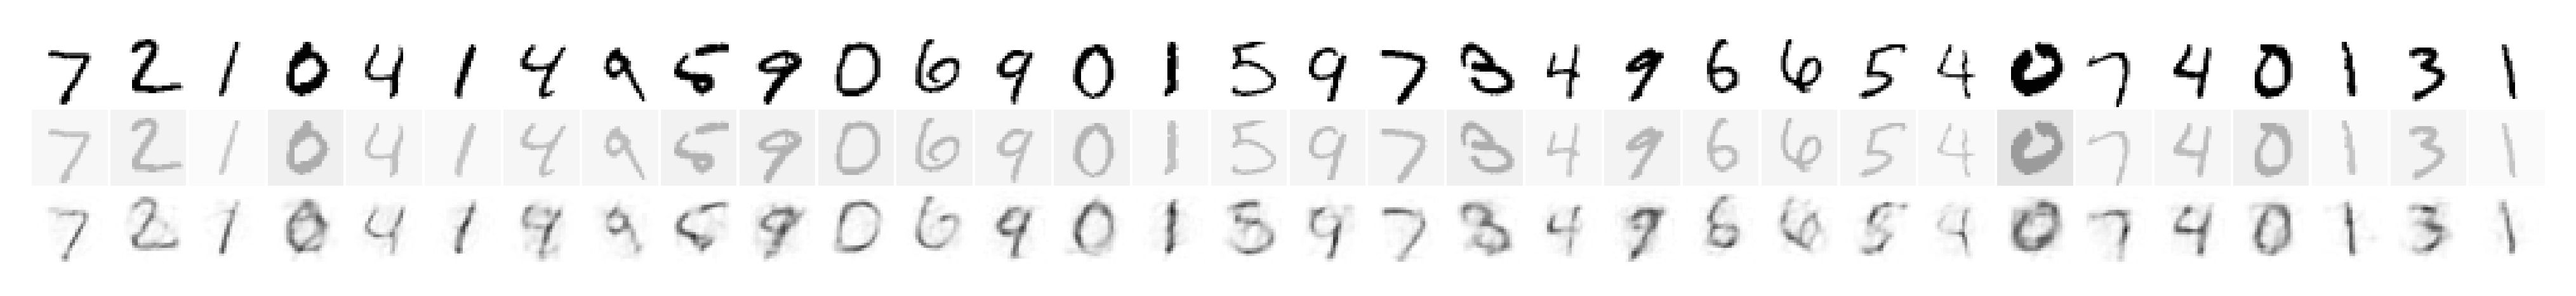

In [28]:
num = 32

x2p = np.concatenate([
    tonp(tr.dl_vld.dataset.tensors[0][:num]),
    corrupted_data['x_corrupted_vld'][:num],
    results['recon'][:num].reshape(tr.model.cfg.shape),
])
_ = plot_weights(x2p, nrows=3, cmap='Greys', method='none', vmin=1e-3, vmax=1.0, dpi=500)

### MSE wrt corrputed

In [29]:
kws['mse_wrt_orig'] = False
results, accuracy = perform_corruption_analysis(**kws)

100%|█████████████████████████████████████████| 300/300 [01:21<00:00,  3.70it/s]


In [30]:
accuracy, results['mse'].mean()

(0.9455, 5.796238)

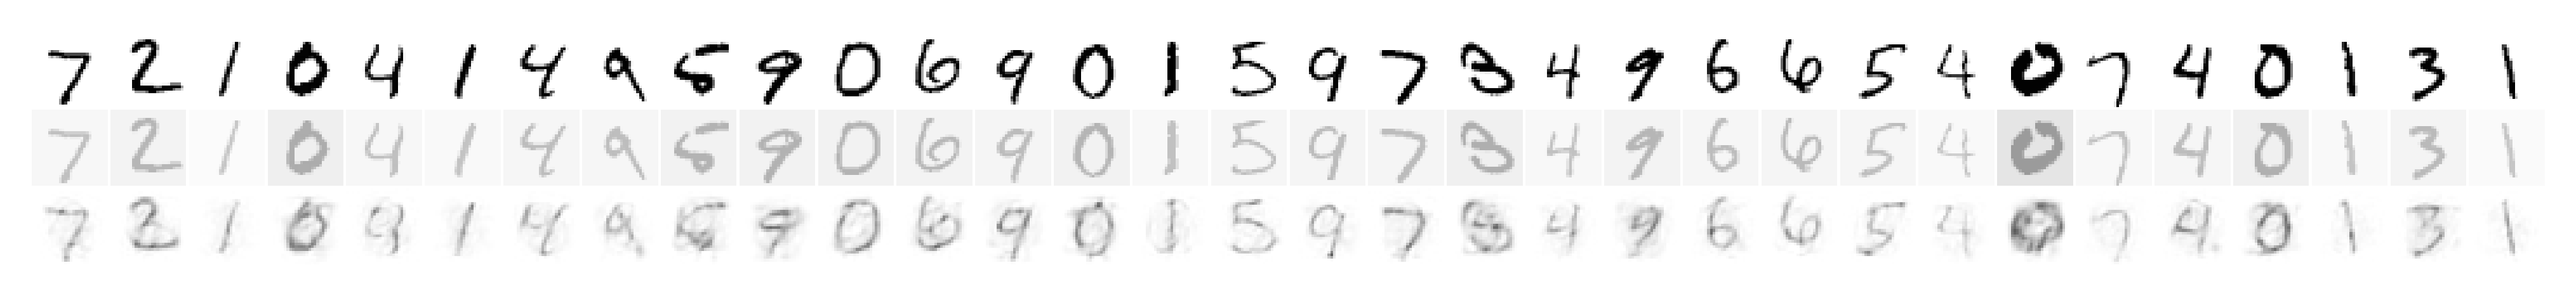

In [31]:
num = 32

x2p = np.concatenate([
    tonp(tr.dl_vld.dataset.tensors[0][:num]),
    corrupted_data['x_corrupted_vld'][:num],
    results['recon'][:num].reshape(tr.model.cfg.shape),
])
_ = plot_weights(x2p, nrows=3, cmap='Greys', method='none', vmin=1e-3, vmax=1.0, dpi=500)

## 5 - Rotate

In [32]:
tgt_ds = 'MNIST'
pat = 'rotate-angle'
val = 90

f = next(
    f for f in files if (
        f.startswith(tgt_ds) and
        f"{pat}-{val}" in f
    )
)
print(f)

MNIST_rotate-angle-90.npy

In [33]:
corrupted_data = np.load(pjoin(load_dir, f), allow_pickle=True).item()
print({k: v for k, v in corrupted_data.items() if not k.startswith('x_')})

{'corruption_type': 'rotate', 'corruption_kws': {'angle': 90, 'hist_match': True, 'interpolation': 'bilinear'}}

In [34]:
kws = dict(
    tr=trainers['poisson_MNIST_(64,24.0)_<jacob|mlp>'],
    corrupted_data=corrupted_data,
    mse_wrt_orig=False,
    t_recon=-1,
    t_halluc=-1,
    hallucinate=False,
    verbose=True,
)
results, accuracy = perform_corruption_analysis(**kws)

100%|█████████████████████████████████████████| 300/300 [01:17<00:00,  3.85it/s]


In [35]:
accuracy, results['mse'].mean()

(0.9467, 9.153117)

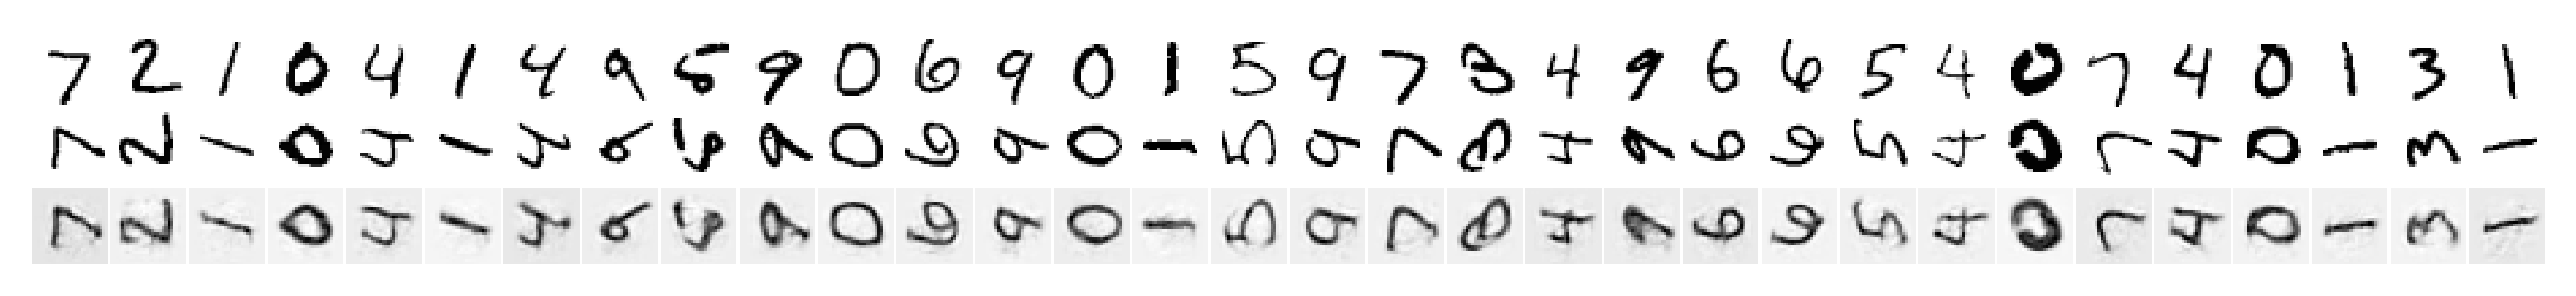

In [36]:
num = 32

x2p = np.concatenate([
    tonp(tr.dl_vld.dataset.tensors[0][:num]),
    corrupted_data['x_corrupted_vld'][:num],
    results['recon'][:num].reshape(tr.model.cfg.shape),
])
_ = plot_weights(x2p, nrows=3, cmap='Greys', dpi=500)

## 6 - Salf & Pepper

In [37]:
tgt_ds = 'MNIST'
pat = 'salt_pepper-amount'
val = 0.5

f = next(
    f for f in files if (
        f.startswith(tgt_ds) and
        f"{pat}-{val}" in f
    )
)
print(f)

MNIST_salt_pepper-amount-0.5.npy

In [38]:
corrupted_data = np.load(pjoin(load_dir, f), allow_pickle=True).item()
print({k: v for k, v in corrupted_data.items() if not k.startswith('x_')})

{'corruption_type': 'salt_pepper', 'corruption_kws': {'amount': 0.5, 'salt_vs_pepper': 0.5}}

In [39]:
kws = dict(
    tr=trainers['poisson_MNIST_(64,24.0)_<jacob|mlp>'],
    corrupted_data=corrupted_data,
    t_recon=-1,
    t_halluc=-1,
    hallucinate=False,
    verbose=True,
)
results, accuracy = perform_corruption_analysis(**kws)

100%|█████████████████████████████████████████| 300/300 [01:22<00:00,  3.65it/s]


In [40]:
accuracy, results['mse'].mean()

(0.7833, 25.36142)

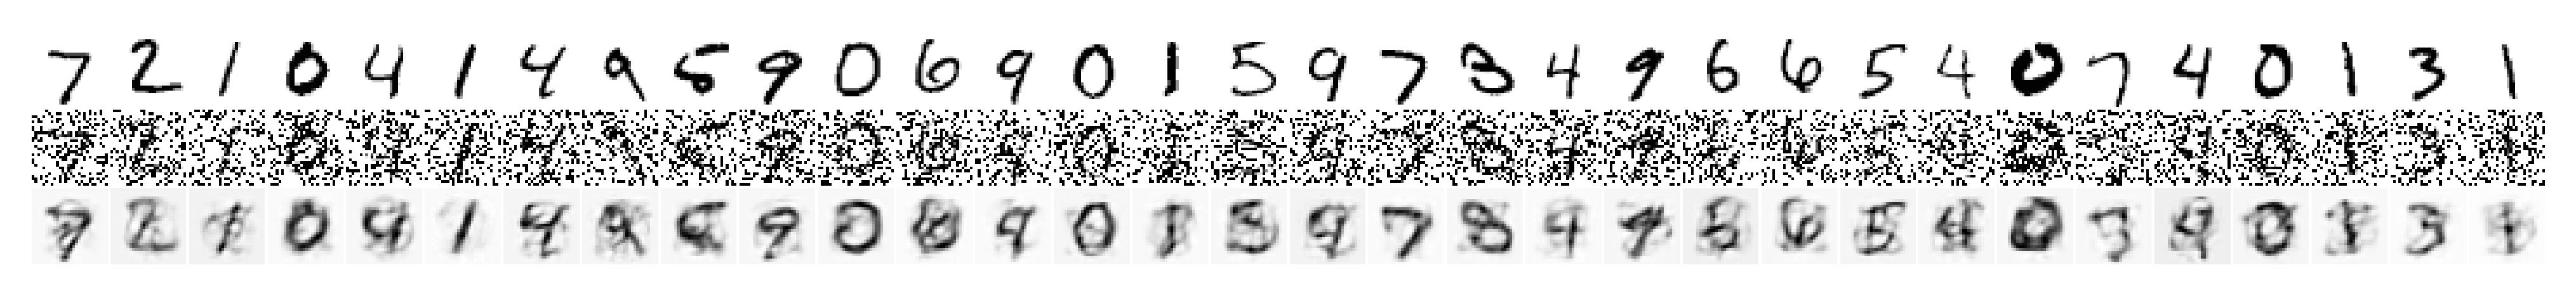

In [41]:
num = 32

x2p = np.concatenate([
    tonp(tr.dl_vld.dataset.tensors[0][:num]),
    corrupted_data['x_corrupted_vld'][:num],
    results['recon'][:num].reshape(tr.model.cfg.shape),
])
_ = plot_weights(x2p, nrows=3, cmap='Greys', dpi=500)